In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""

"""

# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import scipy.constants as cte
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.fftpack import fft, ifft, fftfreq
import scipy.special as sp
from scipy.signal import gaussian

# matplotlib defaults setup
plt.rcParams['figure.dpi'] = 100
#plt.rcParams['savefig.dpi'] = 75
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 14, 8
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "computer modern sans serif"
plt.rcParams['text.usetex']=True
plt.rcParams['text.latex.unicode']=True

# These are the "Tableau 20" colors as RGB.
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# grandezas de interesse em unidades atomicas
au_l = cte.value('atomic unit of length')
au_t = cte.value('atomic unit of time')
au_e = cte.value('atomic unit of energy')

# outras relacoes de interesse
ev = cte.value('electron volt')
c = cte.value('speed of light in vacuum')
hbar_si = cte.value('Planck constant over 2 pi')
me = cte.value('electron mass')
au2ang = au_l / 1e-10
au2ev = au_e / ev

# constantes do problema
E0 = 150.0 # eV
delta_x = 5.0 # angstron
x0 = -30.0 # angstron
xf = -40.0 # angstron
l = 8.1e-6 # m

# otimizando
L = 200 # angstron
N = 4096
hN = int(N/2)
dt = 1e-19 # s

# unidades atomicas
L_au = L / au2ang
dt_au = -1j * dt / au_t
E0_au = E0 / au2ev
delta_x_au = delta_x / au2ang
x0_au = x0 / au2ang
xf_au = xf / au2ang
k0_au = np.sqrt(2 * E0_au)

# malhas direta e reciproca
dx = L / (N-1)
x_au = np.linspace(-L_au/2.0, L_au/2.0, N)
dx_au = np.abs(x_au[1] - x_au[0])
k_au = fftfreq(N, d=dx_au)

# props do material
eg = lambda x: 0.7 * (1.519 + 1.447 * x - 0.15 * x**2) # eV
me_x = lambda x: 0.067+0.083*x
algaas_x = 0.4
Eg = eg(algaas_x)
me_algaas = me_x(algaas_x)
me_gaas = me_x(0.0)
Vb_au = Eg / au2ev
a = 100 # angstron
a_au = a / au2ang
v_au = np.vectorize(lambda x: Vb_au if np.abs(x) > a_au/2 else 0.0)(x_au)
me_eff = np.vectorize(lambda x: me_algaas if np.abs(x) > a_au/2 else me_gaas)(x_au)

# # runge-kutta ordem 4
# alpha = 1j / (2 * me_eff * dx_au ** 2)
# beta = -1j * (v_au + 1.0 / (me_eff * dx_au ** 2))
# diagonal_1 = beta
# diagonal_2 = alpha[1:]
# diagonal_3 = alpha[:-1]
# diagonais = [diagonal_1, diagonal_2, diagonal_3]
# D = diags(diagonais, [0, 1, -1]).toarray()
# def propagador(p):
#     k1 = D.dot(p)
#     k2 = D.dot(p + dt_au * k1 / 2)
#     k3 = D.dot(p + dt_au * k2 / 2)
#     k4 = D.dot(p + dt_au * k3)
#     return p + dt_au * (k1 + 2 * k2 + 2 * k3 + k4) / 6
# propagador_titulo = "Runge-Kutta Ordem 4"

# # crank-nicolson
# alpha = - dt_au * (1j / (2 * me_eff * dx_au ** 2))/2.0
# beta = 1.0 - dt_au * (-1j * (v_au + 1.0 / (me_eff * dx_au ** 2)))/2.0
# gamma = 1.0 + dt_au * (-1j * (v_au + 1.0 / (me_eff * dx_au ** 2)))/2.0
# diagonal_1 = beta
# diagonal_2_1 = alpha[1:]
# diagonal_2_2 = alpha[:-1]
# diagonais = [diagonal_1, diagonal_2_1, diagonal_2_2]
# invB = inv(diags(diagonais, [0, 1, -1]).toarray())
# diagonal_3 = gamma
# diagonal_4_1 = -alpha[1:]
# diagonal_4_2 = -alpha[:-1]
# diagonais_2 = [diagonal_3, diagonal_4_1, diagonal_4_2]
# C = diags(diagonais_2, [0, 1, -1]).toarray()
# D = invB.dot(C)
# propagador = lambda p: D.dot(p)
# propagador_titulo = "Crank-Nicolson"

# split step
me_eff = np.ones(N) * me_gaas
exp_v2 = np.exp(- 0.5j * v_au * dt_au)
exp_t = np.exp(- 0.5j * (2 * np.pi * k_au) ** 2 * dt_au / me_eff)
propagador = lambda p: exp_v2 * ifft(exp_t * fft(exp_v2 * p))
propagador_titulo = "Split-Step"

# chutes iniciais
n = 5
short_grid = np.linspace(-1, 1, N)
g = gaussian(N, std=int(N/50))
estados = np.array([g * sp.legendre(i)(short_grid) for i in range(n)],dtype=np.complex_)
valores = np.zeros(n)
contadores = np.zeros(n)

valores_analiticos_ev = [0.044280126, 0.176480128, 0.394408742, 0.693159988, 1.060713269, 1.438011481]

texto_x_l = -L/2
texto_x_r = 0.7 * L/2

7000 >>> 2.0815e-01 / 4.4280e-02
8000 >>> 1.8478e-01 / 4.4280e-02
9000 >>> 1.6612e-01 / 4.4280e-02
10000 >>> 1.5089e-01 / 4.4280e-02
11000 >>> 1.3822e-01 / 4.4280e-02
12000 >>> 1.2751e-01 / 4.4280e-02
13000 >>> 1.1835e-01 / 4.4280e-02
14000 >>> 1.1043e-01 / 4.4280e-02
15000 >>> 1.0352e-01 / 4.4280e-02
16000 >>> 9.7444e-02 / 4.4280e-02
17000 >>> 9.2069e-02 / 4.4280e-02
18000 >>> 8.7290e-02 / 4.4280e-02
19000 >>> 8.3025e-02 / 4.4280e-02
20000 >>> 7.9205e-02 / 4.4280e-02
21000 >>> 7.5776e-02 / 4.4280e-02
22000 >>> 7.2692e-02 / 4.4280e-02
23000 >>> 6.9913e-02 / 4.4280e-02
24000 >>> 6.7407e-02 / 4.4280e-02
25000 >>> 6.5146e-02 / 4.4280e-02
26000 >>> 6.3104e-02 / 4.4280e-02
27000 >>> 6.1259e-02 / 4.4280e-02
28000 >>> 5.9593e-02 / 4.4280e-02
29000 >>> 5.8088e-02 / 4.4280e-02
30000 >>> 5.6729e-02 / 4.4280e-02
31000 >>> 5.5501e-02 / 4.4280e-02
32000 >>> 5.4392e-02 / 4.4280e-02
33000 >>> 5.3391e-02 / 4.4280e-02
34000 >>> 5.2487e-02 / 4.4280e-02
35000 >>> 5.1672e-02 / 4.4280e-02
36000 >>> 5.0936e

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


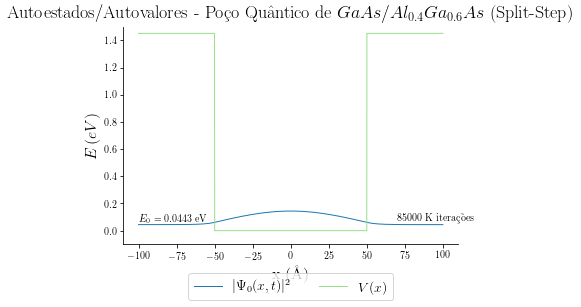

1000 >>> 2.5913e+00 / 1.7648e-01
2000 >>> 1.6993e+00 / 1.7648e-01
3000 >>> 1.2642e+00 / 1.7648e-01
4000 >>> 1.0064e+00 / 1.7648e-01
5000 >>> 8.3600e-01 / 1.7648e-01
6000 >>> 7.1493e-01 / 1.7648e-01
7000 >>> 6.2449e-01 / 1.7648e-01
8000 >>> 5.5436e-01 / 1.7648e-01
9000 >>> 4.9840e-01 / 1.7648e-01
10000 >>> 4.5272e-01 / 1.7648e-01
11000 >>> 4.1475e-01 / 1.7648e-01
12000 >>> 3.8272e-01 / 1.7648e-01
13000 >>> 3.5541e-01 / 1.7648e-01
14000 >>> 3.3191e-01 / 1.7648e-01
15000 >>> 3.1156e-01 / 1.7648e-01
16000 >>> 2.9386e-01 / 1.7648e-01
17000 >>> 2.7843e-01 / 1.7648e-01
18000 >>> 2.6496e-01 / 1.7648e-01
19000 >>> 2.5319e-01 / 1.7648e-01
20000 >>> 2.4291e-01 / 1.7648e-01
21000 >>> 2.3394e-01 / 1.7648e-01
22000 >>> 2.2613e-01 / 1.7648e-01
23000 >>> 2.1933e-01 / 1.7648e-01
24000 >>> 2.1342e-01 / 1.7648e-01
25000 >>> 2.0829e-01 / 1.7648e-01
26000 >>> 2.0385e-01 / 1.7648e-01
27000 >>> 2.0001e-01 / 1.7648e-01
28000 >>> 1.9669e-01 / 1.7648e-01
29000 >>> 1.9382e-01 / 1.7648e-01
30000 >>> 1.9136e-01 / 

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


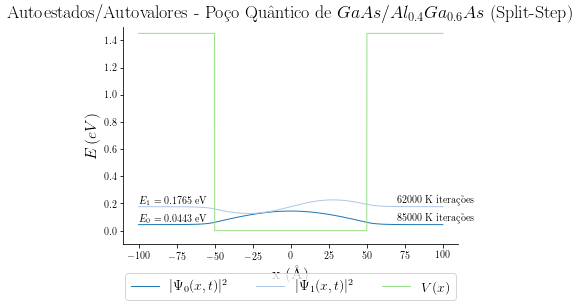

1000 >>> 1.3215e+00 / 3.9441e-01
2000 >>> 9.6659e-01 / 3.9441e-01
3000 >>> 7.9039e-01 / 3.9441e-01
4000 >>> 6.8515e-01 / 3.9441e-01
5000 >>> 6.1552e-01 / 3.9441e-01
6000 >>> 5.6639e-01 / 3.9441e-01
7000 >>> 5.3022e-01 / 3.9441e-01
8000 >>> 5.0277e-01 / 3.9441e-01
9000 >>> 4.8149e-01 / 3.9441e-01
10000 >>> 4.6474e-01 / 3.9441e-01
11000 >>> 4.5141e-01 / 3.9441e-01
12000 >>> 4.4071e-01 / 3.9441e-01
13000 >>> 4.3208e-01 / 3.9441e-01
14000 >>> 4.2509e-01 / 3.9441e-01
15000 >>> 4.1941e-01 / 3.9441e-01
16000 >>> 4.1478e-01 / 3.9441e-01
17000 >>> 4.1101e-01 / 3.9441e-01
18000 >>> 4.0794e-01 / 3.9441e-01
19000 >>> 4.0542e-01 / 3.9441e-01
20000 >>> 4.0337e-01 / 3.9441e-01
21000 >>> 4.0170e-01 / 3.9441e-01
22000 >>> 4.0033e-01 / 3.9441e-01
23000 >>> 3.9921e-01 / 3.9441e-01
24000 >>> 3.9830e-01 / 3.9441e-01
25000 >>> 3.9755e-01 / 3.9441e-01
26000 >>> 3.9695e-01 / 3.9441e-01
27000 >>> 3.9645e-01 / 3.9441e-01
28000 >>> 3.9604e-01 / 3.9441e-01
29000 >>> 3.9571e-01 / 3.9441e-01
30000 >>> 3.9544e-01 / 

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


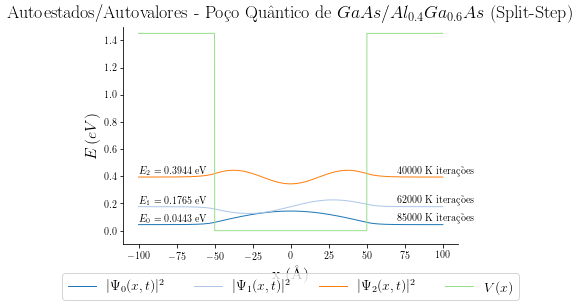

1000 >>> 2.7753e+00 / 6.9316e-01
2000 >>> 1.9120e+00 / 6.9316e-01
3000 >>> 1.5009e+00 / 6.9316e-01
4000 >>> 1.2638e+00 / 6.9316e-01
5000 >>> 1.1118e+00 / 6.9316e-01
6000 >>> 1.0076e+00 / 6.9316e-01
7000 >>> 9.3307e-01 / 6.9316e-01
8000 >>> 8.7806e-01 / 6.9316e-01
9000 >>> 8.3664e-01 / 6.9316e-01
10000 >>> 8.0501e-01 / 6.9316e-01
11000 >>> 7.8061e-01 / 6.9316e-01
12000 >>> 7.6167e-01 / 6.9316e-01
13000 >>> 7.4690e-01 / 6.9316e-01
14000 >>> 7.3534e-01 / 6.9316e-01
15000 >>> 7.2629e-01 / 6.9316e-01
16000 >>> 7.1918e-01 / 6.9316e-01
17000 >>> 7.1360e-01 / 6.9316e-01
18000 >>> 7.0921e-01 / 6.9316e-01
19000 >>> 7.0575e-01 / 6.9316e-01
20000 >>> 7.0303e-01 / 6.9316e-01
21000 >>> 7.0089e-01 / 6.9316e-01
22000 >>> 6.9920e-01 / 6.9316e-01
23000 >>> 6.9786e-01 / 6.9316e-01
24000 >>> 6.9681e-01 / 6.9316e-01
25000 >>> 6.9598e-01 / 6.9316e-01
26000 >>> 6.9533e-01 / 6.9316e-01
27000 >>> 6.9481e-01 / 6.9316e-01
28000 >>> 6.9440e-01 / 6.9316e-01
29000 >>> 6.9407e-01 / 6.9316e-01
30000 >>> 6.9382e-01 / 

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


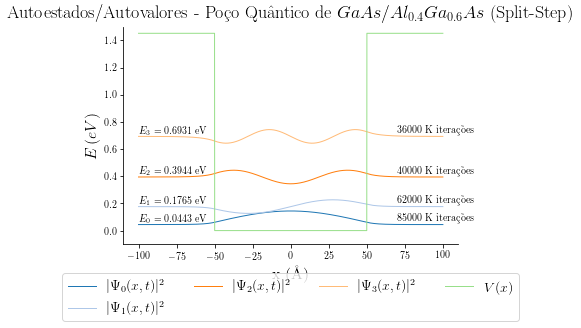

1000 >>> 2.0467e+00 / 1.0607e+00
2000 >>> 1.6422e+00 / 1.0607e+00
3000 >>> 1.4436e+00 / 1.0607e+00
4000 >>> 1.3273e+00 / 1.0607e+00
5000 >>> 1.2526e+00 / 1.0607e+00
6000 >>> 1.2017e+00 / 1.0607e+00
7000 >>> 1.1659e+00 / 1.0607e+00
8000 >>> 1.1400e+00 / 1.0607e+00
9000 >>> 1.1210e+00 / 1.0607e+00
10000 >>> 1.1069e+00 / 1.0607e+00
11000 >>> 1.0962e+00 / 1.0607e+00
12000 >>> 1.0882e+00 / 1.0607e+00
13000 >>> 1.0820e+00 / 1.0607e+00
14000 >>> 1.0773e+00 / 1.0607e+00
15000 >>> 1.0737e+00 / 1.0607e+00
16000 >>> 1.0709e+00 / 1.0607e+00
17000 >>> 1.0687e+00 / 1.0607e+00
18000 >>> 1.0670e+00 / 1.0607e+00
19000 >>> 1.0656e+00 / 1.0607e+00
20000 >>> 1.0646e+00 / 1.0607e+00
21000 >>> 1.0637e+00 / 1.0607e+00
22000 >>> 1.0631e+00 / 1.0607e+00
23000 >>> 1.0625e+00 / 1.0607e+00
24000 >>> 1.0621e+00 / 1.0607e+00
25000 >>> 1.0618e+00 / 1.0607e+00
26000 >>> 1.0615e+00 / 1.0607e+00
27000 >>> 1.0613e+00 / 1.0607e+00
28000 >>> 1.0611e+00 / 1.0607e+00
29000 >>> 1.0610e+00 / 1.0607e+00
30000 >>> 1.0608e+00 / 

/home/thiago/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


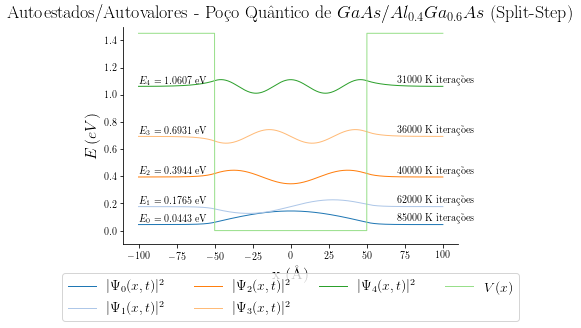

In [3]:
for s in range(n):
    v_ant = 1.0
    while True:
        contadores[s] += 1
        
        estados[s] = propagador(estados[s])
        
        # gram-shimdt
        for m in range(s):
            proj = simps(estados[s] * np.conjugate(estados[m]), x_au)
            estados[s] -= proj * estados[m]
            
        # normaliza
        A = np.sqrt(simps(np.abs(estados[s])**2, x_au))
        estados[s] /= np.sqrt(simps(np.abs(estados[s])**2, x_au))
        
        if contadores[s] % 1000 == 0:
            # calcula autoestados
            # derivada segunda
            derivada2 = (estados[s][:-2] - 2 * estados[s][1:-1] + estados[s][2:]) / dx_au**2
            psi = estados[s][1:-1]
            psi_conj = np.conjugate(psi)
            # <Psi|H|Psi>
            p_h_p = simps(psi_conj * (-0.5 * derivada2 / me_eff[1:-1] + v_au[1:-1] * psi), x_au[1:-1])
            # divide por <Psi|Psi> 
            p_h_p /= A
            valores[s] = p_h_p.real * au2ev # eV
            
            print("%d >>> %.4e / %.4e" % (contadores[s], valores[s], valores_analiticos_ev[s]))
            
            #if np.abs(1-valores[s]/valores_analiticos_ev[s]) < 0.001:
            if np.abs(1-valores[s]/v_ant) < 0.0001:
                # especificos do grafico
                fig = plt.figure()
                ax = fig.add_subplot(1, 1, 1)
                ax.set_ylim([-0.1,1.5])
                ax.spines["top"].set_visible(False)
                ax.spines["right"].set_visible(False)
                plt.title("Autoestados/Autovalores - Poço Quântico de $GaAs/Al_{0.4}Ga_{0.6}As$ (%s)" % (propagador_titulo), fontsize=18)
                plt.xlabel("x (\AA)", fontsize=16)
                plt.ylabel(r'$E \, (eV)$', fontsize=16)

                psif = [estados[m] for m in range(s+1)]
                psif = [0.1 * p / np.ptp(p) + valores[m] for m, p in enumerate(psif)]
                lines = []
                for i, p in enumerate(psif):
                    line, = plt.plot(x_au * au2ang, p, lw=1.0, color=tableau20[i], label=r'$|\Psi_{%d} (x,t)|^2$' % i)
                    lines.append(line)
                    ax.text(texto_x_l, valores[i] + 0.02, r"$E_{%d} = %.4f$ eV" % (i, valores[i]))
                    ax.text(texto_x_r, valores[i] + 0.02, r"$%d$ K iterações" % (contadores[i]))


                linev, = plt.plot(x_au * au2ang, v_au * au2ev, lw=1.0, color=tableau20[n], label='$V(x)$')
                lines.append(linev)
                plt.legend(handles=lines, loc=9, bbox_to_anchor=(0.5, -0.1), ncol=4)
                plt.show()
                break
            else:
                v_ant = valores[s]